In [ ]:
!pip install kaggle

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d nodoubttome/skin-cancer9-classesisic

 99% 777M/786M [00:05<00:00, 189MB/s]
100% 786M/786M [00:05<00:00, 151MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('//content/skin-cancer9-classesisic.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, add, Activation
from keras.models import Model

In [ ]:
# Set up data generator
batch_size = 64
#datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)  # 80-20 split for training-validation

train_datagen = ImageDataGenerator(
    rescale=1./255,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    zoom_range=0.2,
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1/255)
train_generator = train_datagen.flow_from_directory(
        '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train',
        batch_size = 1,
        target_size=(448,448),
        class_mode='binary')

test_generator = test_datagen.flow_from_directory(
        '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Test',
        batch_size = 1,
        target_size=(448,448),
        class_mode='binary')

Found 2239 images belonging to 9 classes.
Found 118 images belonging to 9 classes.


(450, 600, 3)

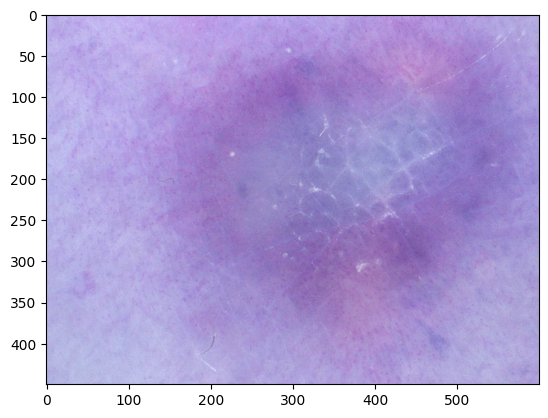

In [ ]:
import cv2
import matplotlib.pyplot as plt
image = cv2.imread("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/ISIC_0025314.jpg")
plt.imshow(image)
image.shape

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, add, Activation
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model

# Enable eager execution
tf.config.run_functions_eagerly(True)

def residual_block(x, filters, kernel_size=(3, 3), strides=(1, 1), activation='relu'):
    """
    Residual block with two convolutional layers.
    """
    y = Conv2D(filters, kernel_size, strides=strides, padding='same', activation=activation)(x)
    y = Conv2D(filters, kernel_size, strides=(1, 1), padding='same')(y)

    # Adjust the dimensions of the input tensor to match the output shape
    if x.shape[-1] != filters:
        x = Conv2D(filters, (1, 1), strides=strides, padding='same')(x)

    # Add the original input to the output (residual connection)
    y = add([x, y])
    y = Activation(activation)(y)
    return y

def create_residual_vgg16(input_shape, num_classes):
    """
    Create a VGG16-like model with residual connections.
    """
    input_tensor = Input(shape=input_shape)

    # Load pre-trained VGG16 model with weights
    base_model = VGG16(weights='imagenet', include_top=False, input_tensor=input_tensor)

    # Freeze layers of the pre-trained VGG16 model
    for layer in base_model.layers:
        layer.trainable = False

    # Output of the pre-trained VGG16 model
    x = base_model.output

    # Add residual block on top of the VGG16 model
    x = residual_block(x, 256)
    x = MaxPooling2D((2, 2))(x)

    # Flatten and fully connected layers
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dense(1, activation='softmax')(x)  # Use num_classes here

    # Create the model
    model = Model(inputs=base_model.input, outputs=x)
    return model

# Define input shape and number of classes
input_shape = (224, 224, 3)  # Adjust based on your input image size
num_classes = 9  # Replace with the actual number of classes in your task

# Create the model
residual_vgg16 = create_residual_vgg16(input_shape, num_classes)
residual_vgg16.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 224, 224, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, 224, 224, 64)         36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)         0         ['block1_conv2[0][0]']        
                             

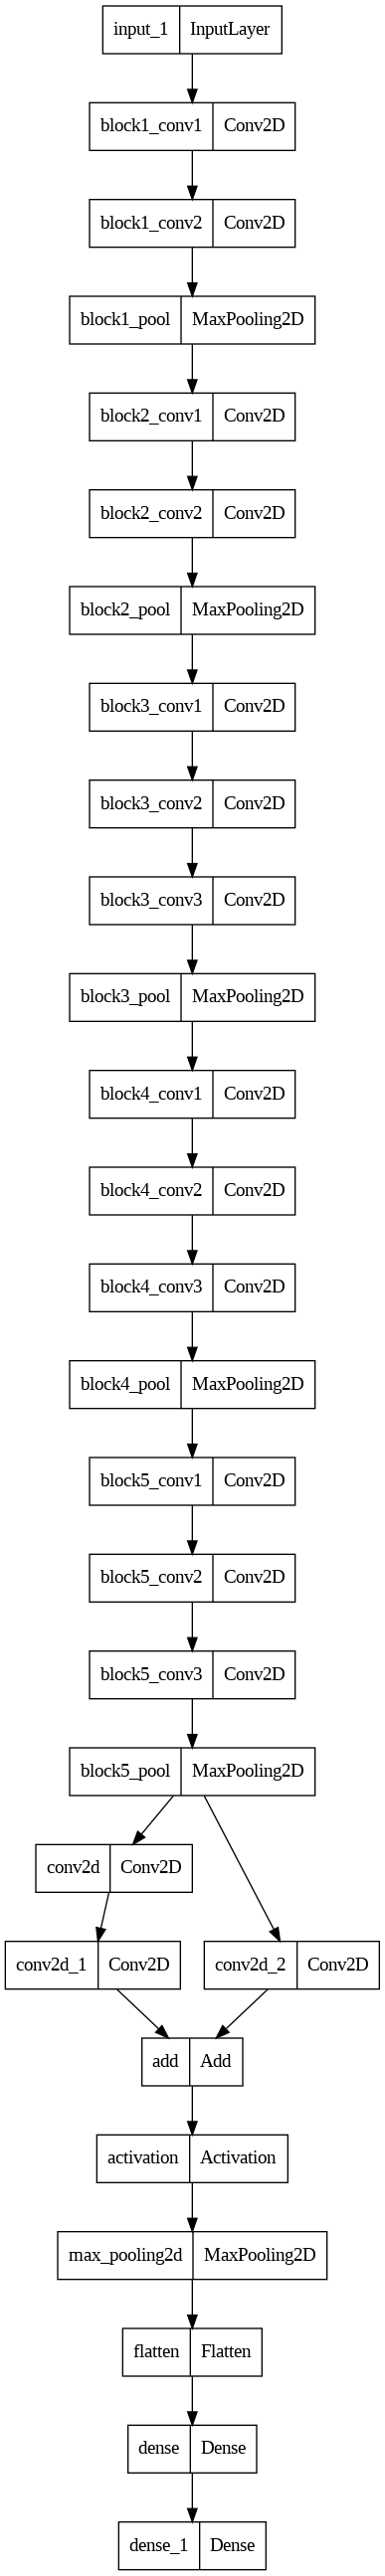

In [ ]:
tf.keras.utils.plot_model(
    residual_vgg16,
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    layer_range=None,
    show_layer_activations=False,
    show_trainable=False,
)

In [ ]:
import warnings
warnings.filterwarnings("ignore")

# Compile and train the model
residual_vgg16.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = residual_vgg16.fit(
    train_generator,
    epochs=10,  # Adjust the number of epochs as needed
)


Epoch 1/10
2239/2239 [==============================] - 212s 90ms/step - loss: 0.0000e+00 - accuracy: 0.1679
Epoch 2/10
2239/2239 [==============================] - 188s 84ms/step - loss: 0.0000e+00 - accuracy: 0.1679
Epoch 3/10
2239/2239 [==============================] - 185s 83ms/step - loss: 0.0000e+00 - accuracy: 0.1679
Epoch 4/10
2239/2239 [==============================] - 186s 83ms/step - loss: 0.0000e+00 - accuracy: 0.1679
Epoch 5/10
2239/2239 [==============================] - 188s 84ms/step - loss: 0.0000e+00 - accuracy: 0.1679
Epoch 6/10
2239/2239 [==============================] - 180s 80ms/step - loss: 0.0000e+00 - accuracy: 0.1679
Epoch 7/10
2239/2239 [==============================] - 181s 81ms/step - loss: 0.0000e+00 - accuracy: 0.1679
Epoch 8/10
2239/2239 [==============================] - 181s 81ms/step - loss: 0.0000e+00 - accuracy: 0.1679
Epoch 9/10
2239/2239 [==============================] - 181s 81ms/step - loss: 0.0000e+00 - accuracy: 0.1679
Epoch 10/10
2239/22

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, add, Activation
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model

# Enable eager execution
tf.config.run_functions_eagerly(True)

def residual_block(x, filters, kernel_size=(3, 3),strides=(1, 1), activation='relu'):
    """
    Residual block with two convolutional layers.
    """
    y = Conv2D(filters, kernel_size, padding='same', activation=activation)(x)
    y = Conv2D(filters, kernel_size, padding='same')(y)

    # Adjust the dimensions of the input tensor to match the output shape
    if x.shape[-1] != filters:
        x = Conv2D(filters, (1, 1), strides=strides, padding='same')(x)

    # Add the original input to the output (residual connection)
    y = add([x, y])
    y = Activation(activation)(y)
    return y

def create_residual_vgg16(input_shape, num_classes):
    """
    Create a VGG16-like model with residual connections.
    """
    input_tensor = Input(shape=input_shape)

    # Load pre-trained VGG16 model with weights
    base_model = VGG16(weights='imagenet', include_top=False, input_tensor=input_tensor)

    # Freeze layers of the pre-trained VGG16 model
    for layer in base_model.layers:
        layer.trainable = False

    # Output of the pre-trained VGG16 model
    x = base_model.output

    # Add residual block after Block 1
    block1 = residual_block(x, 64)
    x = MaxPooling2D((2, 2))(block1)

    # Add residual block after Block 2
    block2 = residual_block(x, 128)
    x = MaxPooling2D((2, 2))(block2)

    # Add residual block after Block 3
    block3 = residual_block(x, 256)
    x = MaxPooling2D((2, 2))(block3)

    # Flatten and fully connected layers
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dense(1, activation='softmax')(x)

    # Create the model with skip connections
    model = Model(inputs=base_model.input, outputs=x)

    return model

# Define input shape and number of classes
input_shape = (448,448, 3)  # Adjust based on your input image size
num_classes = 9  # Replace with the actual number of classes in your task

# Create the model
residual_vgg16 = create_residual_vgg16(input_shape, num_classes)
residual_vgg16.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 448, 448, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 448, 448, 64)         1792      ['input_5[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, 448, 448, 64)         36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 224, 224, 64)         0         ['block1_conv2[0][0]']        
                                                                                            

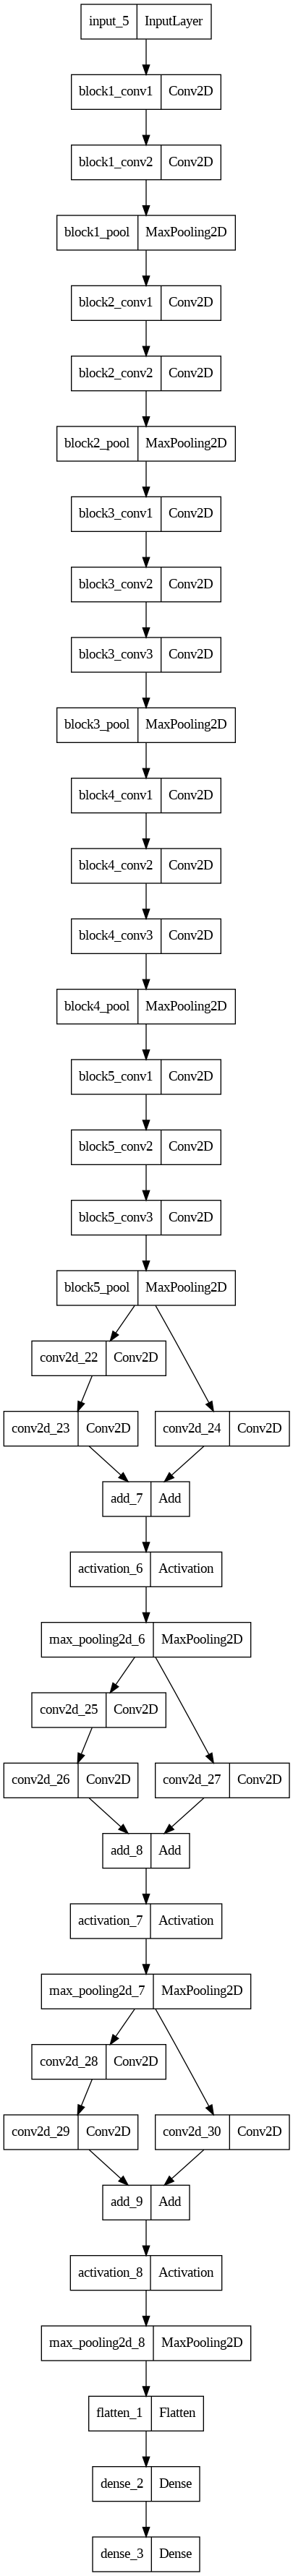

In [ ]:
tf.keras.utils.plot_model(
    residual_vgg16
)

In [ ]:
# Compile and train the model
residual_vgg16.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = residual_vgg16.fit(
    train_generator,
    epochs=10,  # Adjust the number of epochs as needed
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(1, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


2239/2239 [==============================] - 335s 147ms/step - loss: nan - accuracy: 0.0670
Epoch 2/10
2239/2239 [==============================] - 328s 147ms/step - loss: nan - accuracy: 0.0509
Epoch 3/10
2239/2239 [==============================] - 329s 147ms/step - loss: nan - accuracy: 0.0509
Epoch 4/10
2239/2239 [==============================] - 325s 145ms/step - loss: nan - accuracy: 0.0509
Epoch 5/10
2239/2239 [==============================] - 316s 141ms/step - loss: nan - accuracy: 0.0509
Epoch 6/10
2239/2239 [==============================] - 317s 141ms/step - loss: nan - accuracy: 0.0509
Epoch 7/10
2239/2239 [==============================] - 316s 141ms/step - loss: nan - accuracy: 0.0509
Epoch 8/10
2239/2239 [==============================] - 316s 141ms/step - loss: nan - accuracy: 0.0509
Epoch 9/10
2239/2239 [==============================] - 316s 141ms/step - loss: nan - accuracy: 0.0509
Epoch 10/10
2239/2239 [==============================] - 315s 140ms/step - loss: nan